# About this notebook

Information theoretic model selection allows to extract metrics of relative model importance from model likelihood estimations. From a set of N models, we can then identify which model is the best for predictions on the basis of it having the lowest information theoretic criterion (e.g. AIC). Importantly, such metrics penalize models with too many parameters, thereby limitting the risk of overfitting. Although appealing, this procedure however neglects uncertainty in model importance ranking, which results from a finite sample size. 

To account for model importance uncertainty, we can calculate model IT weights, as the probability of each model to be the best model for predictions. If a model has a weight of e.g. > 0.95, there is a good chance that it is the best model in the set for predictions. If however no model weight in the set exceeds e.g. 0.3, then there is uncertainty in model ranking and about which model to use for predictions.

Luckily, we can perform so called multimodel inference. This consists of using estimates from several models with good enough fit together, in order to build an average model which supposedly performs better at predicting new data than any other model in the set. This is done by averaging estimated parameters across all considered models, weighted by model weights. When applying so-called 'full averaging', predictors which do not appear in models have their estimated parameter set to 0, such that, if a predictor is absent from models with large weights, its averaged parameter will naturally shrink towards 0. 

Such a shrinkage is reminiscent of other statistical methods intended to penalize estimated parameter values to avoid overfitting, such as regularization methods like Ridge, Lasso, or Elastic net regressions. Contrary to IT model averaging, such methods involve hyperparameter optimization during cross validation, a potentially time and ressource expensive algorithmic method.

Our goal here is therefore to evaluate the relative benefits of IT multimodel inference and regularization techniques to avoid overfitting during model selection. Beyond simple curiosity about methods relative performance, the use of IT model averaging instead of regularization mais significantly increase model training time.

# Load dependencies

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import itertools as iter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

import MultiModInf as mmi

# Generating data

We start with generating data from a multivariate normal distribution, with a set variance covariance structure. 

## no collinearity among predictors

In [2]:
nb_predictors = 10
means = np.random.uniform(0, 20, nb_predictors + 1)
vars = np.random.uniform(0, 20, nb_predictors + 1)
betas = np.array([0.8, 0.6])
betas = np.append(betas, np.random.uniform(0, 0.1, nb_predictors-2))
betas

array([0.8       , 0.6       , 0.04126562, 0.06635065, 0.05096743,
       0.03055736, 0.04402632, 0.09485831, 0.09005211, 0.02062223])

In [3]:
d = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=200)
d

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,6.165009,8.946096,11.724311,14.936689,10.169531,5.635144,2.498156,15.705789,2.543009,5.277909,6.026267
1,2.201358,8.507572,8.008628,10.675156,6.238288,0.881622,2.763393,15.017277,3.654004,4.233672,6.858481
2,7.890837,9.770079,16.327912,7.830221,4.497615,1.893734,1.563839,16.170082,4.451925,-0.301317,4.759669
3,6.059324,10.230375,11.943636,19.197261,6.440996,6.468234,2.326587,10.067632,3.487315,3.881771,1.134979
4,7.174345,13.493144,10.990241,12.278563,4.802407,1.599508,1.914034,12.316501,3.176964,-6.836226,11.457447
...,...,...,...,...,...,...,...,...,...,...,...
195,2.604713,10.287885,6.437792,14.777675,7.153183,1.932360,3.477670,10.685765,2.019181,1.248305,9.060799
196,8.573981,13.364624,11.599159,7.699657,5.758487,-0.445881,1.101307,15.104636,2.808194,3.316365,7.610476
197,4.678883,9.467842,11.138311,15.124614,6.413604,0.395824,3.011447,17.742460,2.438252,4.498788,8.505056
198,9.810249,11.354005,14.899114,15.554365,6.823762,10.023357,2.527564,16.270967,3.848715,3.201403,6.359387


## with colinearity

In [7]:
means_multcol = np.random.uniform(0, 20, nb_predictors + 1)
vars_multcol = np.random.uniform(0, 20, nb_predictors + 1)
betas_multcol = np.array([0.8, 0.6])
betas_multcol = np.append(betas_multcol, np.random.uniform(0, 0.1, nb_predictors-2))

In [8]:
d_multcol = mmi.generate_multivariate_data(means = means_multcol, vars = vars_multcol, coefs = betas_multcol, sample_size=200, multicolinearity=True, colin_range=(0, 0.4))
d_multcol

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,4.739947,6.071285,16.436534,6.195238,18.376324,4.826927,15.299956,18.792445,7.225654,7.160959,6.763949
1,5.369990,7.641585,21.109305,4.037957,20.731699,6.425041,15.552007,20.107439,22.304770,12.772130,12.042914
2,0.606184,6.008962,14.747759,6.877129,21.666211,3.395926,13.442529,19.257246,16.051198,14.937444,12.975292
3,7.078504,12.452983,16.845656,8.238879,19.699957,4.663027,18.012765,19.637253,21.037234,12.469736,15.143451
4,5.790260,6.333518,16.572617,4.146434,17.830113,4.264035,18.035169,19.305930,14.915401,4.608824,5.445403
...,...,...,...,...,...,...,...,...,...,...,...
195,8.470802,12.453178,14.726484,7.091853,18.777318,4.193093,12.593546,18.740384,8.577178,12.021139,10.675400
196,4.657193,9.618286,19.723175,7.350865,21.341969,5.457498,17.799258,19.562965,22.182182,12.978345,13.858943
197,7.838565,10.288891,16.898406,6.873287,18.727704,6.498068,15.951095,19.247105,12.698926,8.808842,4.290387
198,5.560587,6.900867,17.414965,4.858594,18.821841,5.685644,16.943141,19.508447,16.200811,5.462674,7.534980


## data representation

In [9]:
df = d.copy()
# df = d_multcol.copy()

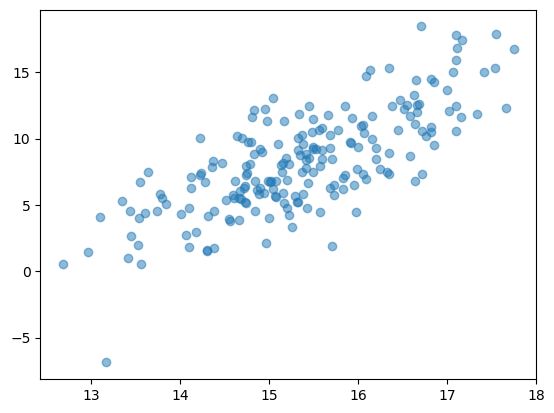

In [10]:
plt.plot(df['x1'], df['y'], 'o', alpha = 0.5);

In [11]:
print(pearsonr(df['x1'], df['y'])[0])
print(pearsonr(df['x2'], df['y'])[0])
print(pearsonr(df['x3'], df['y'])[0])
print(pearsonr(df['x4'], df['y'])[0])

0.7487159734433491
0.6645234850272319
0.09907288842464612
-0.0004398275882431871


# Multi model inference

In [4]:
variables = [f'x{v}' for v in range(1,len(vars))]
variables

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

## fitting models on unscalled data

In [50]:
# fitting all possible models
models_all = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations='all')
# fitting models for all combinations of 2 predictors
models_2 = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations=2)
models_2.head()

,model,intercept,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,AIC,deltaAIC,AIC weight
0,"[x1, x2]",-20.212618,1.212768,0.540945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.476052,0,1.000000e+00
1,"[x1, x6]",-12.443007,1.282839,NaN,NaN,NaN,NaN,0.097524,NaN,NaN,NaN,NaN,888.399688,460.923636,8.160263e-101
2,[x1],-12.197222,1.276393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,894.471915,466.995863,3.918653e-102
3,"[x1, x8]",-12.563554,1.268609,NaN,NaN,NaN,NaN,NaN,NaN,0.052777,NaN,NaN,894.573509,467.097458,3.724567e-102
4,"[x1, x5]",-12.243327,1.277298,NaN,NaN,NaN,0.124299,NaN,NaN,NaN,NaN,NaN,895.575616,468.099565,2.256686e-102


In [51]:
models_all.head()

,model,intercept,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,AIC,deltaAIC,AIC weight
0,"[x1, x2, x4, x6, x8, x9, x10]",-23.148123,1.214138,0.544328,NaN,0.03218,NaN,0.078248,NaN,0.070767,0.094703,0.054797,289.727627,0,0.349980
1,"[x1, x2, x3, x4, x6, x8, x9, x10]",-23.158098,1.213268,0.544586,0.005184,0.032621,NaN,0.078882,NaN,0.070499,0.09558,0.05446,291.351419,1.623792,0.155397
2,"[x1, x2, x4, x5, x6, x8, x9, x10]",-23.130462,1.214412,0.544011,NaN,0.031718,0.013027,0.078736,NaN,0.070519,0.093773,0.05499,291.523677,1.79605,0.142573
3,"[x1, x2, x4, x6, x7, x8, x9, x10]",-23.08643,1.213874,0.544388,NaN,0.032465,NaN,0.077971,-0.00343,0.070686,0.094109,0.05498,291.611153,1.883526,0.136471
4,"[x1, x2, x3, x4, x5, x6, x8, x9, x10]",-23.140045,1.213536,0.544264,0.005275,0.032152,0.013446,0.079397,NaN,0.070238,0.094635,0.054653,293.133853,3.406226,0.063737


We can here observe that, when considering all possible model combinations in the set, there is uncertainty about which model is the best for predictions. We can then perform model averaging, before evaluating model performance when predicting new datacgenerated from the same multivariate normal distribution.

## model averaging

In [39]:
avg_estimates_all = mmi.model_averaging(models_all, variables)
avg_estimates_2 = mmi.model_averaging(models_2, variables)

# Averaged model fit to new data

We generate new data from the same distributions used to create the training data.

In [40]:
new_data = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=100)
# new_data = mmi.generate_multivariate_data(means = means_multcol, vars = vars_multcol, coefs = betas_multcol, sample_size=100, multicolinearity=True, colin_range=(0, 0.4))
new_data

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/MultiModInf.py:106: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,7.428643,15.090022,16.010164,-8.051708,2.955322,1.554356,18.577236,13.113652,10.851775,17.708212,4.134550
1,11.740712,16.300095,20.759814,-3.382230,-0.224017,0.026474,9.118733,19.918383,3.702077,19.131204,6.707254
2,6.712271,15.034506,14.839585,5.392564,3.309778,-2.105972,0.976240,16.580556,9.278590,20.945027,7.444335
3,8.218798,17.027412,16.038329,1.679531,9.422388,-0.319818,-1.214825,14.916566,8.065631,19.754427,-4.813863
4,9.514106,14.830000,20.665184,-2.611506,3.738804,0.350094,5.846174,14.809721,5.318978,20.322703,9.680393
...,...,...,...,...,...,...,...,...,...,...,...
95,11.234868,18.668609,16.920669,5.497210,-0.415988,-0.158151,-3.940314,17.310682,10.555091,16.714127,6.790259
96,7.029587,14.482334,18.567963,-1.165364,-2.699077,0.207190,-0.919719,15.192331,11.015946,18.087758,9.767835
97,12.821648,16.205083,22.405328,2.245789,8.776518,-0.874533,2.122862,18.591817,14.638646,20.863048,4.068771
98,11.515728,15.134564,24.420013,-3.537406,-0.942473,-0.620843,-2.367449,17.678097,10.973775,20.344749,4.357787


In [41]:
model_params_all = avg_estimates_all
model_params_2 = avg_estimates_2
y_pred_avg_all = mmi.prediction(model_params_all, new_data)
y_pred_avg_2 = mmi.prediction(model_params_2, new_data)
best_model_params_all = models_all.loc[0, ['intercept'] + variables]
best_model_params_2 = models_2.loc[0, ['intercept'] + variables]
best_model_params_all = best_model_params_all.dropna()
best_model_params_2 = best_model_params_2.dropna()
y_pred_best_all = mmi.prediction(best_model_params_all, new_data)
y_pred_best_2 = mmi.prediction(best_model_params_2, new_data)

In [42]:
mse_avg_all = mean_squared_error(new_data['y'], y_pred_avg_all)
mse_best_all = mean_squared_error(new_data['y'], y_pred_best_all)
print(mse_avg_all)
print(mse_best_all)
mse_avg_2 = mean_squared_error(new_data['y'], y_pred_avg_2)
mse_best_2 = mean_squared_error(new_data['y'], y_pred_best_2)
print(mse_avg_2)
print(mse_best_2)

0.261198777832753
0.26325441889325985
0.5460175677180766
0.5460175677180766


In [43]:
mse_all = []
for i in models_all.index:
    model_params = models_all.loc[i, ['intercept'] + variables]
    model_params = model_params.dropna()
    y_pred = mmi.prediction(model_params, new_data)
    mse_all.append(mean_squared_error(new_data['y'], y_pred))

In [44]:
mse_2 = []
for i in models_2.index:
    model_params = models_2.loc[i, ['intercept'] + variables]
    model_params = model_params.dropna()
    y_pred = mmi.prediction(model_params, new_data)
    mse_2.append(mean_squared_error(new_data['y'], y_pred))

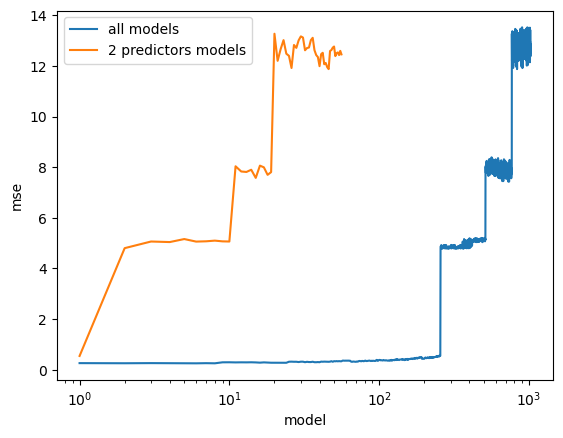

In [48]:
plt.plot(models_all.index + 1, mse_all, label = 'all models')
plt.plot(models_2.index + 1, mse_2, label = '2 predictors models')
plt.xscale('log')
plt.xlabel('model')
plt.ylabel('mse')
plt.legend()

# Sytematic approach

We can then evaluate averaged model performance accross several sample sizes and several parameter correlation structures. We expect that averaged model will perform consistently better at predicting new data than the best ranked model.

As a second step, we can then compare averaged model performance with that of regularization methods involving hyperparameter tuning through cross validation

## mse and sample sizes

In [13]:
# population parameters
N_vec = np.arange(20, 500, 20)
iterations = 50
nb_predictors = 6
means = np.random.uniform(0, 20, nb_predictors + 1)
vars = np.random.uniform(0, 20, nb_predictors + 1)
betas = np.array([0.8, 0.6])
betas = np.append(betas, np.random.uniform(0, 0.1, nb_predictors-2))
variables = [f'x{v}' for v in range(1,len(vars))]
# test data
new_data = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=100)

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


In [19]:
mse = []
mse3 = []
for N in N_vec:
    for i in range(iterations):
        df = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=N)
        models = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations='all')
        models_3 = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations=3)
        avg_estimates = mmi.model_averaging(models, variables)
        avg_estimates_3 = mmi.model_averaging(models_3, variables)
        y_pred = mmi.prediction(avg_estimates, new_data)
        y_pred_3 = mmi.prediction(avg_estimates_3, new_data)
        mse.append(mean_squared_error(new_data['y'], y_pred))
        mse3.append(mean_squared_error(new_data['y'], y_pred_3))

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/m

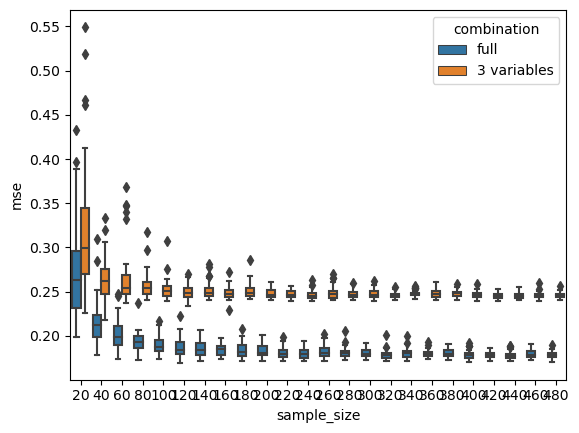

In [38]:
results = pd.DataFrame({
    'sample_size':np.append(np.repeat(N_vec, iterations),
                                  np.repeat(N_vec, iterations)),
    'mse': np.append(mse, mse3),
    'combination':np.append(np.repeat('full', iterations*len(N_vec)), 
                                  np.repeat('3 variables', iterations*len(N_vec))),
})
sns.boxplot(x = 'sample_size', y = 'mse', data = results, hue = 'combination');


## comparison to regularization methods

In [70]:
# population parameters
nb_predictors = 10
means = np.random.uniform(0, 20, nb_predictors + 1)
vars = np.random.uniform(0, 20, nb_predictors + 1)
betas = np.array([0.8, 0.6])
betas = np.append(betas, np.random.uniform(0, 0.1, nb_predictors-2))
variables = [f'x{v}' for v in range(1,len(vars))]
# test data
new_data = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=100)

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


In [71]:
df = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=N)
X = df.drop(columns = 'y')
y = df['y']
X_test = new_data.drop(columns = 'y')
y_test = new_data['y']

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


### multimodel inference

In [72]:
models = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations='all')
avg_estimates = mmi.model_averaging(models, variables)
y_pred_mmi = mmi.prediction(avg_estimates, new_data)
mse_mmi = mean_squared_error(y_test, y_pred_mmi)
print(mse_mmi)

0.052875516985724055


### regularization

In [73]:
ridge = RidgeCV(cv=5)
lasso = LassoCV(cv=5, random_state=0)
elnet = ElasticNetCV(cv=5, random_state=0)

In [74]:
ridge.fit(X, y)
lasso.fit(X, y)
elnet.fit(X, y)

ElasticNetCV(cv=5, random_state=0)

In [75]:
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
y_pred_elnet = elnet.predict(X_test)
mse_elnet = mean_squared_error(y_test, y_pred_elnet)
print(mse_ridge)
print(mse_lasso)
print(mse_elnet)

0.052761047276902416
0.052682466925616775
0.05267991253140063


### systematic

In [76]:
# population parameters
N_vec = np.arange(20, 500, 20)
iterations = 10
nb_predictors = 6
means = np.random.uniform(0, 20, nb_predictors + 1)
vars = np.random.uniform(0, 20, nb_predictors + 1)
betas = np.array([0.8, 0.6])
betas = np.append(betas, np.random.uniform(0, 0.1, nb_predictors-2))
variables = [f'x{v}' for v in range(1,len(vars))]
# test data
new_data = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=100)

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols


In [77]:
mse_mmi = []
mse_ridge = []
mse_lasso = []
mse_elnet = []
for N in N_vec:
    for i in range(iterations):
        df = mmi.generate_multivariate_data(means = means, vars = vars, coefs = betas, sample_size=N)
        X = df.drop(columns = 'y')
        y = df['y']
        X_test = new_data.drop(columns = 'y')
        y_test = new_data['y']
        # model averaging
        models = mmi.multi_model_inf(df, response = 'y', variables = variables, combinations='all')
        avg_estimates = mmi.model_averaging(models, variables)
        y_pred = mmi.prediction(avg_estimates, new_data)
        mse_mmi.append(mean_squared_error(new_data['y'], y_pred))
        # regularization
        ridge = RidgeCV(cv=5)
        lasso = LassoCV(cv=5, random_state=0)
        elnet = ElasticNetCV(cv=5, random_state=0)
        ridge.fit(X, y)
        lasso.fit(X, y)
        elnet.fit(X, y)
        y_pred_ridge = ridge.predict(X_test)
        mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))
        y_pred_lasso = lasso.predict(X_test)
        mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))
        y_pred_elnet = elnet.predict(X_test)
        mse_elnet.append(mean_squared_error(y_test, y_pred_elnet))
        

/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/matthiasgalipaud/Documents/portfolio projects/model selection ML/multi-model-regularization/MultiModInf.py:105: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(means, covs, sample_size), columns=cols
/Users/m

In [86]:
results = pd.DataFrame({
    'sample_size':np.hstack((np.repeat(N_vec, iterations),
                            np.repeat(N_vec, iterations),
                            np.repeat(N_vec, iterations),
                            np.repeat(N_vec, iterations))),
    'mse': np.hstack((mse_mmi, mse_ridge, mse_lasso, mse_elnet)),
    'method':np.hstack((np.repeat('model averaging', iterations*len(N_vec)), 
                            np.repeat('ridge', iterations*len(N_vec)),
                            np.repeat('lasso', iterations*len(N_vec)),
                            np.repeat('elnet', iterations*len(N_vec)))),
})

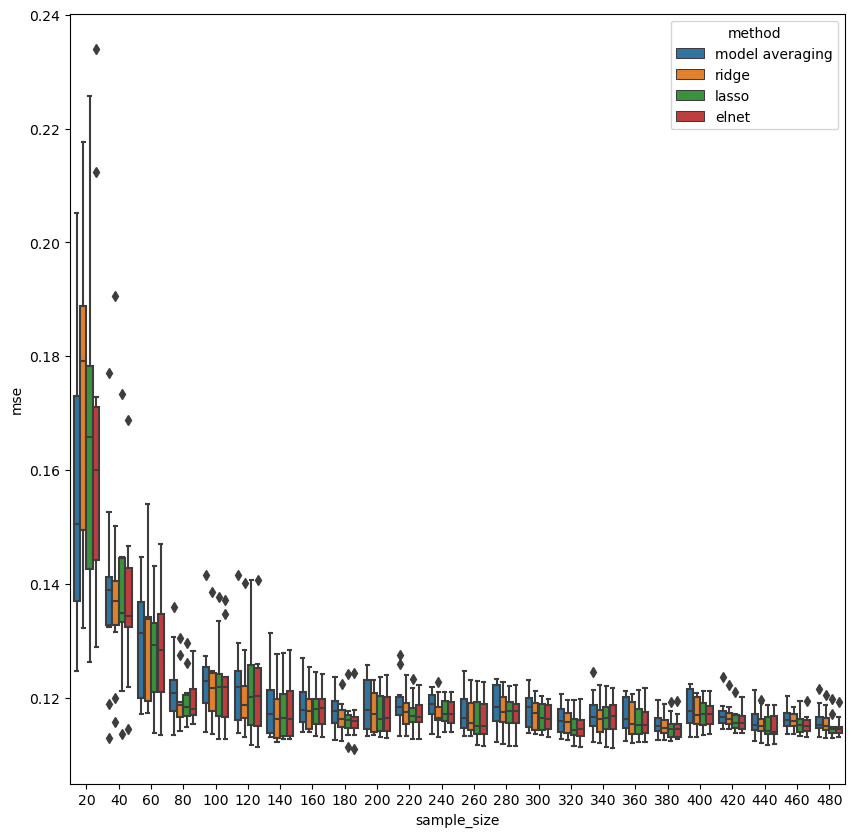

In [87]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(x = 'sample_size', y = 'mse', data = results, hue = 'method', ax = ax);